# Lab 7: Building an Agentic RAG Workflow with LangGraph

This lab guides you through the design and implementation of a modular, agentic Retrieval-Augmented Generation (RAG) system using LangGraph. 

![Workflow](https://i.imgur.com/gHOMuWs.png)

**Core Features Implemented**
- Multi-Agent Collaboration
  
  Specialized agents (e.g., Query Router, Answer Generator, Verifier) work together to deliver robust, high-quality responses.

- Adaptive Retrieval Routing

  Inspired by Adaptive RAG, the system dynamically selects between vectorstore, web search, or fallback dialogue based on the question’s intent.

- Fallback Mechanism (Corrective RAG)
  
  Based on Corrective RAG, the system falls back to web search if retrieved documents are weak or irrelevant.

- Self-Correction & Reflection
  
  Following Self-RAG, the system performs hallucination detection and answer usefulness checks, triggering retries or rewrites when needed.

- Performance Considerations

  - Efficiency: Uses async document grading to speed up multi-query retrieval.
  - Failure Handling: Implements structured retry logic with maximum retry limits.

The lab consists of three main phases: 
1. Define Agent Functions. 
2. Build the Workflow with LangGraph.  
3. Run the Workflow. 

In [ ]:
# %pip install -Uq langchain langchain_community langgraph


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Environment Configuration
from dotenv import load_dotenv  
import os
from sqlalchemy.engine.url import make_url # Used to parse and construct database URLs
from langchain_postgres.vectorstores import PGVector # Integration with Postgres + pgvector for vector storage

# LLM and Core LangChain Tools
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI

from langchain_core.messages import HumanMessage, SystemMessage
from langchain.load import dumps, loads  # Serialize/deserialize LangChain objects
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser 
from langchain_core.documents import Document # # Standard document format used in LangChain pipelines

from typing_extensions import TypedDict # Define structured types for state management
from typing import List  # Specify types for list inputs or outputs
import asyncio # Support asynchronous execution for parallel LLM calls

from langgraph.graph import StateGraph, END # LangGraph tools to define stateful workflows 

# Visualization and Display Utilities
import textwrap
from IPython.display import Markdown, Image
from pprint import pprint

# Web Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults

In [2]:
# Load environment variables from .env file
load_dotenv()

# Access the environment variable
openai_api_key = os.getenv("OPENAI_API_KEY")
connection_string = os.getenv("DB_CONNECTION")
tavily_api_key =os.getenv("TAVILY_API_KEY")

# Configure Database Connection
# Use the same shared table as from the last lab
shared_connection_string = make_url(connection_string)\
    .set(database="IST345_Drucker_data").render_as_string(hide_password=False) # Leave password visible for local testing

# Initialize the embedding model
embedding_model = OpenAIEmbeddings(model="text-embedding-3-large")

# Quick check environment variables
if not openai_api_key or not shared_connection_string or not tavily_api_key or not embedding_model:
    print(f"Error: Missing one or more required environment variables") # If so, print out your key to check
else:
    print("All environment variables loaded successfully")

All environment variables loaded successfully


In [4]:
# Main LLM for handling complex or creative tasks
llm_gpt = ChatOpenAI(
    model="gpt-4o", # GPT-4o is a powerful model with strong reasoning capabilities
    temperature=0.7,
    api_key = openai_api_key
)

# Lightweight LLM for simple or deterministic tasks
llm_gpt_mini = ChatOpenAI(
    model="gpt-4o-mini",    #  Smaller, faster variant for lightweight tasks
    temperature=0,          # Temperature 0 = fully deterministic output
    api_key = openai_api_key
)

# Connect to the PGVector Vector Store that contains book data.
book_data_vector_store = PGVector(
    embeddings = embedding_model,   
    collection_name = "Book_data",   # Name of the collection/table in the vector DB
    connection=shared_connection_string, # Use shared DB connection from earlier
    use_jsonb=True, 
)

## 1\. Define Agents
In this section, we define the different agents used in the workflow. 

### 1\.1 Query Router Agent
The Query Router is an LLM-powered decision-making agent that analyzes a user’s question and determines the most appropriate information source to handle it.

It uses a structured prompt to classify the query into one of three categories:
1. A vector search for questions answerable by the existing content in our Drucker book collection.
2. A web search for in-scope questions that require more factual, comprehensive, or real-time information.
3. A fallback "Chitter-Chatter" agent for out-of-scope question. 

In [5]:
# Define the routing prompt
query_router_prompt_template = PromptTemplate.from_template("""
You are an expert at analyzing user question and deciding which data source is best suited to answer them. You must choose **one** of the following options:

1. **Vectorstore**: Use this if the question can be answered by the **existing** content in the vectorstore. 
   The vectorstore contains information about **{vectorstore_content_summary}**.
                                                            
---                                                         
                                                                                                                          
2. **Websearch**: Use this if the question is **within scope** (see below) but meets **any** of the following criteria:
    - The answer **cannot** be found in the local vectorstore
    - The question requires **more detailed or factual information** than what's available in the books (e.g. exact birth date, current events or references)
    - The topic is **time-sensitive** , **current**, or depends on recent events or updates    
                                                                                                                
---                                                         
                                                              
3. **Chitter-Chatter**: Use this if the question:
   - Is **not related** to the scope below, or
   - Is too **broad, casual, or off-topic** to be answered using vectorstore or websearch.
   
   Chitter-Chatter is a fallback agent that gives a friendly response and a follow-up to guide users back to relevant topics.
                                                            
---
                                                            
Scope Definition:
Relevant questions are those related to **{relevant_scope}**

---                                                        

Your Task:
Analyze the user's question. Return a JSON object with one key `"Datasource"` and one value: `"Vectorstore"`, `"Websearch"`, or `"Chitter-Chatter"`.

""")

# Define a summary of what's in the vectorstore
# This helps the LLM understand what kind of information is already available.
# It gets embedded into the prompt above dynamically.
vectorstore_content_summary = """
Peter Drucker's "The Daily Drucker" (2004) provides 366 daily insights and actionable advice on management, leadership, and innovation, 
serving as a practical guide for personal and professional growth. "The Effective Executive" (2002) emphasizes the habits and practices that 
enable executives to achieve effectiveness, focusing on time management, prioritization, and decision-making. "The Essential Drucker" (2008) 
is a curated collection of Drucker's foundational principles on management, strategy, and leadership, offering timeless guidance for navigating 
complex business environments. These books collectively address key aspects of effective management and leadership, making them valuable 
resources for understanding organizational dynamics and personal productivity.
"""

# Define the topical scope of the system
# This defines what topics are considered "in-scope" for this assistant or application.
# It also gets embedded into the prompt above dynamically.
relevant_scope = """Peter Drucker-related topics, including his management philosophy, leadership principles, innovation strategies, 
and their applications in modern business contexts"""

# Format the prompt using the content summary and scope
# The final formatted prompt is what will be sent to the LLM to determine routing.
query_router_prompt = query_router_prompt_template.format(
    relevant_scope = relevant_scope,
    vectorstore_content_summary = vectorstore_content_summary
)

In [6]:
# Test Query Router

# Example user questions for testing
questions = [
    "Who is Peter Drucker, and where was he born?",
    "What did Drucker say about knowledge workers in the book?",
    "How are you doing today?"
]

print(f"\n{'='*40} Testing the Router Prompt {'='*40}\n")

# Loop through test questions and print routing decisions
for q in questions:
    response = llm_gpt.with_structured_output(method="json_mode").invoke(
        [SystemMessage(content=query_router_prompt), # Use the formatted routing prompt
        HumanMessage(content=q)] # Feed in the user query
    )
    
    # Extract and print the decision
    print(f"Question: {q}")
    print(f"Datasource: {response['Datasource']}")
    print("-" * 50)


======================================== Testing the Router Prompt ========================================

Question: Who is Peter Drucker, and where was he born?
Datasource: Websearch
--------------------------------------------------
Question: What did Drucker say about knowledge workers in the book?
Datasource: Vectorstore
--------------------------------------------------
Question: How are you doing today?
Datasource: Chitter-Chatter
--------------------------------------------------


### 1\.2 Document Retriever Agent
This agent retrieves relevant documents using a multi-step retrieval strategy:
- Multi-query generation: Rewrites the user’s question in different ways to improve recall.
- MMR retrieval: Finds diverse, relevant documents for each query variant.
- Reciprocal Rank Fusion: Combines and reranks results to prioritize the most consistently relevant documents.

The result is a high-quality, reranked list of documents optimized for use in the workflow.

#### Step 1. Query translation
Use an LLM to generate multiple alternative versions of a user query.

Because semantic similarity search (in vector DBs) can miss relevant results, we use query translation to improve recall.

In [14]:
# Define the multi-query generation prompt
# The prompt gives the LLM both context about the vectorstore and a specific instruction

multi_query_generation_prompt = PromptTemplate.from_template("""
You are an AI assistant helping improve document retrieval in a vector-based search system.

---
                                                             
**Context about the database**
The vectorstore contains the following content:
{vectorstore_content_summary}

Your goal is to help retrieve **more relevant documents** by rewriting a user's question from multiple angles.
This helps compensate for the limitations of semantic similarity in vector search.

---

**Instructions**:
Given the original question and the content summary above:
1. Return the **original user question** first.
2. Then generate {num_queries} **alternative versions** of the same question.
    - Rephrase using different word choices, structure, or focus.
    - Use synonyms or shift emphasis slightly, but keep the original meaning.
    - Make sure all rewrites are topically relevant to the database content.

Format requirements:
- Do **not** include bullet points or numbers.
- Each version should appear on a **separate newline**.
- Return **exactly {num_queries} + 1 total questions** (1 original + {num_queries} new ones).  

---                                              

**Original user question**: {question}
""")

# Create the query generation pipeline
multi_query_generator = (
    multi_query_generation_prompt   # The prompt defines what the LLM should do
    | llm_gpt                       # An LLM generates query variants
    | StrOutputParser()             # Parses the raw output as a string
    | (lambda x: x.split("\n"))   # A lambda function to split the result into a list of strings (each query)
)

In [15]:
# === Test Query Translation ===

# Run the query generator with example input
test_query_translation = multi_query_generator.invoke(
{"question":"What did Drucker say about knowledge workers in the book?",
 "num_queries":3,   # number of alternative versions to generate
 "vectorstore_content_summary":vectorstore_content_summary
 })

# Print results in a readable format
print(f"\n{'='*40} Testing the Query Translation Prompt {'='*40}\n")

for i, query in enumerate(test_query_translation):
    if i == 0:
        print(f"Original query: {query}")
    else:
        print(f"Generated query {i}: {query}")


======================================== Testing the Query Translation Prompt ========================================

Original query: What did Drucker say about knowledge workers in the book?  
Generated query 1: How does Drucker address the concept of knowledge workers within his writings?  
Generated query 2: In his works, what insights does Drucker offer regarding knowledge workers?  
Generated query 3: What are Drucker's thoughts on the role of knowledge workers as discussed in his books?  


#### Step 2. RAG fusion
This section implements a RAG Fusion retrieval strategy that is similar to the Lab 6.

Each version of the query from the previous step is used to retrieve documents from the vectorstore using MMR (Maximal Marginal Relevance).

Then the results from all query variations are reranked using Reciprocal Rank Fusion. 

In [16]:
# Reciprocal Rank Fusion (RRF) Implementation 
def reciprocal_rank_fusion(results, k=60):
    fused_scores = {}  # Dictionary to store cumulative RRF scores for each document

    # Iterate through each ranked list of documents
    for docs in results:
        for i, doc in enumerate(docs):
            doc_str = dumps(doc)    # Convert document to a string format (JSON) to use as a dictionary key

            # Initialize the document's fused score if not already present
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0

            # Apply RRF scoring: 1 / (rank + k), where rank is 1-based
            rank = i + 1  # Adjust rank to start from 1 instead of 0
            fused_scores[doc_str] += 1 / (rank + k)

    # Sort by cumulative RRF score (descending)
    reranked_results = sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)

    # Convert JSON strings back to Document objects and store RRF scores in metadata
    reranked_documents = []
    for doc_str, score in reranked_results:
        doc = loads(doc_str)  # Convert back to Document object
        doc.metadata["rrf_score"] = score  # Track how the document was ranked
        reranked_documents.append(doc)

    # Return the list of documents with scores embedded in metadata
    return reranked_documents

In [17]:
# Define a retrieval chain for Multi-Query RAG fusion

retrieval_chain_rag_fusion_mmr = (
    multi_query_generator  
    | book_data_vector_store.as_retriever(
        search_type="mmr", # Use MMR retrieval to enhance diversity in retrieved documents
        search_kwargs={
            'k': 3,             # Final number of documents to return per query
            'fetch_k': 15,      # Initial candidate pool (larger for better diversity)
            "lambda_mult": 0.5  # Balances relevance (0) and diversity (1)
            }
            ).map()  # Apply MMR retrieval to each reformulated query 
    | reciprocal_rank_fusion # Rerank the combined results using RRF
)

In [18]:
# === Test the RAG Fusion Retrieval Pipeline ===

rag_fusion_mmr_results = retrieval_chain_rag_fusion_mmr.invoke({
    "question":"What did Drucker say about knowledge workers in the book?",
    "num_queries":3,
    "vectorstore_content_summary":vectorstore_content_summary})

print(f"\n{'='*40} Testing the reranked retrieved results {'='*40}\n")

# Display the total number of retrieved and reranked documents
print(f"Total number of results: {len(rag_fusion_mmr_results)}")

# Iterate through the retrieved documents and display them in a structured format
for i, doc in enumerate(rag_fusion_mmr_results, start=1):
    # Display metadata: Source and page number
    display(Markdown(f"\n **From `{doc.metadata['source']}`, page {doc.metadata['page']}**"))

    # Display the score
    print(f"RRF score: {doc.metadata['rrf_score']:.4g}") # Display the score with 4 decimal places

    # Print the document content with proper text wrapping for better readability
    print(textwrap.fill(doc.page_content, width=100)) 

    # Add a separator for each document
    print("—" * 80) 


======================================== Testing the reranked retrieved results ========================================

Total number of results: 7


C:\Users\yuyum\AppData\Local\Temp\ipykernel_48028\1905607030.py:24: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  doc = loads(doc_str)  # Convert back to Document object



 **From `The Daily Drucker-2004.pdf`, page 806**

RRF score: 0.04788
. Drucker analyzes the new realities of strategy, shows how to be a leader in periods of change, and
explains the “New Information Revolution,” discussing the information an executive needs and the
information an executive owes. He also examines knowledge-worker productivity, and shows that
changes in the basic attitude of individuals and organizations, as well as structural changes in
work itself, are needed for increased productivity. Finally, Drucker addresses the ultimate
challenge of
————————————————————————————————————————————————————————————————————————————————



 **From `The Essential Drucker-2008.pdf`, page 196**

RRF score: 0.03279
. Knowledge  workers, after all, first came into being in any substantial numbers a generation ago.
(I coined the  term “knowledge worker” years ago.)   But also the shift from manual workers who do
as they are being told—either by the task or by the  boss—to knowledge workers who have to manage
themselves profoundly challenges social  structure
————————————————————————————————————————————————————————————————————————————————



 **From `The Effective Executive-2002.pdf`, page 17**

RRF score: 0.03279
.  It takes his knowledge and uses it as the resource, the motivation, and the vision of  other
knowledge workers. Knowledge workers are rarely in phase with each other,  precisely because they
are knowledge workers. Each has his own skill and his own  concerns. One man may be interested in
tax accounting or in bacteriology, or in training  and developing tomorrow’s key administrators in
the city government
————————————————————————————————————————————————————————————————————————————————



 **From `The Daily Drucker-2004.pdf`, page 321**

RRF score: 0.032
. 5. Productivity of the knowledge worker is not—at least not primarily—a matter of the quantity of
output. Quality is at least as important. 6. Finally, knowledge-worker productivity requires that
the knowledge worker be both seen and treated as an “asset” rather than a “cost.” It requires that
knowledge workers want to work for the organization in preference to all other opportunities. ACTION
POINT: Apply steps one through five to your knowledge work. Management Challenges for the 21st
Century
————————————————————————————————————————————————————————————————————————————————



 **From `The Daily Drucker-2004.pdf`, page 800**

RRF score: 0.01613
. According to Peter Drucker, “This book tries to equip the manager with the understanding, the
thinking, the knowledge, and the skills for today’s and also tomorrow’s jobs.” This management
classic has been developed and tested during more than thirty years of management teaching in
universities, executive programs, seminars, and through the author’s close work with managers as a
consultant for large and small businesses, government agencies, hospitals, and schools
————————————————————————————————————————————————————————————————————————————————



 **From `The Daily Drucker-2004.pdf`, page 321**

RRF score: 0.01613
23 May Knowledge-Worker Productivity Knowledge-worker productivity requires that the knowledge
worker be both seen and treated as an asset rather than a cost. W ork on the productivity of the
knowledge worker has barely begun. But we already know a good many of the answers. We also know the
challenges to which we do not yet know the answers. Six major factors determine knowledge-worker
productivity. 1. Knowledge-worker productivity demands that we ask the question: “What is the task?”
2
————————————————————————————————————————————————————————————————————————————————



 **From `The Daily Drucker-2004.pdf`, page 323**

RRF score: 0.01587
. They know what steps are most important and what methods need to be used to complete the tasks;
and it is their knowledge that tells them what chores are unnecessary and should be eliminated. Work
on knowledge-worker productivity therefore begins with asking the knowledge workers themselves: What
is your task? What should it be? What should you be expected to contribute? and What hampers you in
doing your task and should be eliminated? The how only comes after the what has been answered
————————————————————————————————————————————————————————————————————————————————


### 1\.3 Relevance Grader Agent
This agent evaluates whether a retrieved document is relevant to a user’s question.

It uses an LLM to determine if the document contains **keyword overlap** or **semantic alignment** with the query. 

The output is a simple `"pass"` or `"fail"` label in JSON format, useful for:
- Filtering out low-quality documents in RAG pipelines.
- Scoring retrieval effectiveness.
- Constructing feedback loops for reranking or refinement.

In [19]:
# Define the relevance grader prompt
relevance_grader_prompt_template = PromptTemplate.from_template("""
You are a a relevance grader evaluating whether a retrieved document is helpful in answering a user question.

---

**Retrieved Document**: 
{document}

**User Question**: 
{question}

---

**Your Task**:                                                          
Carefully and  objectively assess whether the document contains any **keyword overlap** or **semantic meaning** that is relevant to the question.
Do not require a full answer—just some relevant content is enough to pass.

Return your decision as a JSON object with twith keys: "binary_score". 
The "binary_score" should be "pass" or "fail" indicating relevance.
""")

In [20]:
# === Test Relevant Grader ===

# Format the prompt with the first document from the reranked RAG fusion results
relevance_grader_prompt = relevance_grader_prompt_template.format(
    document=rag_fusion_mmr_results[0].page_content,
    question="What did Drucker say about knowledge workers in the book?"
)

# Invoke the grading agent using a lightweight model
grader_result = llm_gpt_mini.with_structured_output(method="json_mode").invoke(
    relevance_grader_prompt)

# Print the grading result
print(f"\n{'='*40} Testing Relevance Grader Prompt {'='*40}\n")
print(grader_result)


======================================== Testing Relevance Grader Prompt ========================================

{'binary_score': 'pass'}


### 1\.4 Answer Generator Agent
This agent uses context-relevant documents to generate an answer to the user's question.

It is grounded in retrieved content and includes a reference section at the end of the response.

In [21]:
# Define the prompt template for answer generation
answer_generator_prompt_template = PromptTemplate.from_template("""
You are an assistant for question-answering tasks.

---

**Context**:
Use the following information to help answer the question:
{context}

****User Question**:
{question}
                                                                
---
                                                                
**Instructions**:
1. Base your answer primarily on the context provided.
2. If the answer is **not present** in the context, say so explicitly.
3. Keep the answer **concise**, **accurate**, and **focused** on the question.
4. At the end, include a **reference section**:
    - For book-based sources, use **APA-style citations** if possible.
    - For web-based sources, include **page title and URL**.

---
                                                                
**Answer**:
""")

In [22]:
# === Test Answer Generator ===

# Set up a test question and format the documents for input
test_question = "What did Drucker say about knowledge workers in the book?"

# Convert LangChain Documents into a simplified format (only metadata and page content)
formatted_doc_results = [{"metadata": doc.metadata, "page_content": doc.page_content} for doc in rag_fusion_mmr_results]

# Format the final prompt with documents and question
answer_generator_prompt = answer_generator_prompt_template.format(
    context=formatted_doc_results,  # Test with all documents
    question=test_question
)

# Generate an answer using the main LLM
answer_generation = llm_gpt.invoke(answer_generator_prompt)
print(f"\n{'='*40} Testing Answer Generator Prompt {'='*40}\n")

# Display the question and answer in a readable format
display(Markdown(f"**Question:** {test_question}\n"))
display(Markdown(f"**Answer:** {answer_generation.content}"))


======================================== Testing Answer Generator Prompt ========================================



**Question:** What did Drucker say about knowledge workers in the book?


**Answer:** Peter Drucker discussed several key aspects of knowledge workers in his writings. He emphasized that knowledge workers require a shift from being seen as a cost to being considered an asset to organizations. Productivity for knowledge workers is not just about the quantity of output but also the quality. Drucker also highlighted that knowledge workers should manage themselves and be involved in determining their tasks, understanding their contributions, and identifying obstacles in their work. He coined the term "knowledge worker" and noted the transition from manual work to knowledge work as a profound change in the social structure.

**Reference**:
Drucker, P. F. (2004). *The Daily Drucker: 366 Days of Insight and Motivation for Getting the Right Things Done*.  
Drucker, P. F. (2008). *The Essential Drucker*.

### 1\.5 Hallucination Checker Agent
This agent evaluates whether an answer is factually grounded in the provided source documents.

It compares the generated answer against reference material and returns:
- A binary grade (``"pass"`` or ``"fail"``)
- A brief explanation justifying the decision

It's useful for detecting hallucinations in LLM output and enforcing groundedness in your GenAI application. 

In [23]:
# Define the hallucination checker prompt
# The grader compares a student-style answer to reference materials (i.e., retrieved documents) and
# checks for accuracy, fabrication, or unsupported claims.

hallucination_checker_prompt_template = PromptTemplate.from_template("""
You are an AI grader evaluating whether a student's answer is factually grounded in the provided reference materials.

---

**Grading Criteria**:
- **Pass**: The answer is **fully based** on the given FACTS and does not contain any fabricated or incorrect claims.
- **Fail**: The answer information that is **fabricated**, **inaccurate**, or **not supported** by the source material.

---

**Reference Materials (FACTS)**:
{documents}

**Student's Answer**:
{generation}

---

**Output Instructions**:
Return a JSON object with keys: "binary_score" and "explanation".  
- "binary_score": either `"pass"` or `"fail"`
- `"explanation"`: a short justification of the grading decision                                                                     
""")


In [24]:
# === Test Hallucination Checker Prompt ===

# Format the prompt with the provided documents and generated answer
hallucination_checker_prompt = hallucination_checker_prompt_template.format(
    documents=formatted_doc_results, 
    generation=answer_generation.content
)

# Use the mini LLM model to grade the document
hallucination_checker_result = llm_gpt_mini.with_structured_output(method="json_mode").invoke(
    hallucination_checker_prompt)

# Print the parsed JSON responses

print(f"\n{'='*40} Testing Hallucination Checker Prompt {'='*40}\n")

# Display the grade
display(Markdown(f"**Grade:** {hallucination_checker_result['binary_score']}"))

# Display the explanation
display(Markdown(f"**Explanation:** {hallucination_checker_result['explanation']}"))


======================================== Testing Hallucination Checker Prompt ========================================



**Grade:** pass

**Explanation:** The student's answer accurately reflects key concepts from Drucker's writings, including the importance of viewing knowledge workers as assets, the emphasis on quality over quantity in productivity, and the self-management of knowledge workers. All claims made in the answer are supported by the reference materials.

### 1\.6 Answer Verifier Agent 
This agent evaluates whether a generated answer meaningfully responds to the user’s original question.

It does not assess factual accuracy; only whether the answer is relevant, responsive, and on-topic.

It returns a ``"pass"`` or ``"fail"`` grade, along with a brief explanation. 

This is useful in the workflow to ensure answers stay aligned with user intent.

In [25]:
# Define the answer verifier prompt
# The LLM is asked to judge whether the answer is responsive, relevant, and coherent with the original question.

answer_verifier_prompt_template = PromptTemplate.from_template("""
You are an AI grader verifying whether a student's answer correctly addresses the given question.

---

**Grading Criteria**:
- **Pass**: The answer directly addresses the question, even if it includes additional relevant context.
- **Fail**: The answer is off-topic, misses the point, or does not meaningfully respond to the question.

---

**question**: 
{question}

**Student's Answer**: 
{generation}

---
                                                               
**Output Instructions**:
Return aJSONobject with keys: "binary_score" and "explanation"  
- "binary_score": either `"pass"` or `"fail"` 
- "explanation":  a short justification for your grading decision
""")


In [26]:
# === Test Answer Verifier Prompt ===

#Format the prompt with a test question and its generated answer
answer_verifier_prompt = answer_verifier_prompt_template.format(
    question=test_question, 
    generation=answer_generation.content
)

# Use the mini LLM model to grade the document
answer_verifier_result = llm_gpt_mini.with_structured_output(method="json_mode").invoke(
    answer_verifier_prompt)

# Print the parsed JSON responses
print(f"\n{'='*40} Testing Answer Verifier Prompt {'='*40}\n")

# Display the grade
display(Markdown(f"**Grade:** {answer_verifier_result['binary_score']}"))

# Display the explanation
display(Markdown(f"**Explanation:** {answer_verifier_result['explanation']}"))


======================================== Testing Answer Verifier Prompt ========================================



**Grade:** pass

**Explanation:** The student's answer directly addresses the question by summarizing Drucker's views on knowledge workers, including their value to organizations, the importance of self-management, and the transition from manual to knowledge work. This response is relevant and informative.

### 1\.7 Query Rewriter
This agent improves search effectiveness by rewriting user questions that previously led to incomplete or irrelevant answers.

It reviews both the original question and the failed answer to detect gaps, ambiguities, or missed keywords.

The output includes:
- A rewritten question optimized for vector retrieval
- An explanation of how the rewrite improves the search

This is useful for query recovery, workflow feedback loops, and retrieval optimization.

In [28]:
# Define the query rewriter prompt

query_rewriter_prompt_template = PromptTemplate.from_template("""
You are a query optimization expert tasked with rewriting questions to improve vector database retrieval accuracy.

---

**Context**:
- Original Question: {question}
- Previous Answer (incomplete or unhelpful): {generation}

**Vectorstore Summary**:
{vectorstore_content_summary}
                                                              
Note: The summary provides context about what's in the database but should not be treated as exhaustive.                                                       

---

**Your Task**:
Analyze the original question and the failed answer to identify:
1. What key information the original question was missing
2. Any ambiguities or unclear phrasing
3. Missing context or specialized terminology that should be included
4. Better keywords, phrasing, or terms to improve retrieval

---
                                                              
**Output Format**:
Return a JSON object with keys: "rewritten_question" and "explanation".
- "rewritten_question":  A refined version of the user's question optimized for vector search
- "explanation": A short explanation of how the rewrite improves coverage or clarity
""")

In [29]:
# === Test Query Rewriter Prompt ===

# Format the prompt with actual values
query_rewriter_prompt = query_rewriter_prompt_template.format(
    question=test_question, 
    generation=answer_generation.content,
    vectorstore_content_summary = vectorstore_content_summary
)

# Use the LLM model to grade the document
query_rewriter_result = llm_gpt.with_structured_output(method="json_mode").invoke(
    query_rewriter_prompt)

# Print the parsed JSON responses
print(f"\n{'='*40} Testing Query Rewriter Prompt {'='*40}\n")

# Display the original question
display(Markdown(f"**Original Question:** {test_question}"))

# Display the rewritten question
display(Markdown(f"**Rewritten Question:** {query_rewriter_result['rewritten_question']}"))

# Display the explanation
display(Markdown(f"**Explanation:** {query_rewriter_result['explanation']}"))


======================================== Testing Query Rewriter Prompt ========================================



**Original Question:** What did Drucker say about knowledge workers in the book?

**Rewritten Question:** What insights does Peter Drucker provide about the role and management of knowledge workers in 'The Daily Drucker' and 'The Essential Drucker'?

**Explanation:** The revised question specifies the books 'The Daily Drucker' and 'The Essential Drucker', which aligns with the context provided by the vectorstore summary, improving the retrieval accuracy by pinpointing the sources where Drucker discusses knowledge workers. It also clarifies the request for insights on the role and management of knowledge workers, using precise terminology that matches Drucker's focus areas, thus reducing ambiguity and enhancing relevance.

### 1\.8 Chitter-Chatter Agent
This agent is a friendly fallback assistant that handles:
- Off-topic or unrelated questions
- In-scope but unanswerable questions
- Casual, social dialogue (e.g., greatings) with a friendly tone

It never fabricates or guesses answers. Instead, it acknowledges the user’s input, maintains a warm tone, and gently redirects the conversation toward more relevant or answerable topics within the defined scope.

In [30]:
# Define the Chitter-Chatter prompt
chitterchatter_prompt_template = PromptTemplate.from_template("""
You are a friendly assistant designed to keep conversations within the current scope while maintaining a warm, helpful tone.

---

**Current Scope**:
{relevant_scope}

Your job is to respond conversationally while gently guiding the user toward relevant and productive discussions.

---
                                                              
**Response Guidelines**:

1. **Casual Chit-Chat**:
  - Respond warmly to greetings and social exchanges. 
  - Maintain a natural, friendly tone.

2. **Off-Topic Questions**:  
  - Politely acknowledge the question.  
  - Mention that it falls outside your current scope.  
  - Redirect to a relevant topic or ask a follow-up question within scope.
  - Avoid saying "I don't know" without offering guidance.

3. **In-Scope but Unanswerable Questions**:                                                            
  - If the question fits the scope but lacks enough information to answer reliably:
    - Acknowledge the gap.
    - Avoid making unsupported claims.                                                    
    - Redirect the user toward a more specific or better-supported question.

---

**Important**: 
Never invent or guess answers using general world knowledge. 
Your job is to **maintain trust** by keeping the conversation focused and grounded.
                                                              
Always end with a helpful redirection, question, or suggestion related to the scope above.
""")

In [31]:
# === Test Chitter-Chatter Prompt ===

# Format the prompt using the defined relevant scope
chitterchatter_prompt = chitterchatter_prompt_template.format(relevant_scope=relevant_scope)

# Run a test with a casual or off-topic input
chitterchatter_response = llm_gpt_mini.invoke(
    [SystemMessage(chitterchatter_prompt),
     HumanMessage("How are you doing today?")]
)

print(f"\n{'='*40} Testing Chitter-Chatter Prompt {'='*40}\n")

# Display the result
display(Markdown(f"**Response:** {chitterchatter_response.content}"))


======================================== Testing Chitter-Chatter Prompt ========================================



**Response:** I'm doing great, thank you! How about you? Is there something specific about Peter Drucker's management philosophy or leadership principles that you're interested in discussing today?

### 1\.9 Web Searcher
This agent performs real-time web searches using Tavily's search API. This is the same Web Search tool you defined previously. 

It is ideal for answering:
- In-scope questions that require additional detail beyond the vectorstore
- Questions involving current events, specific dates, or external references
- Queries needing factual grounding or external verification

This specific agent returns up to 5 high-quality search results, including:
- A short summary answer (if available)
- Title, URL, snippet, and a relevance score for each result

In [32]:
# Define the web search tool

web_search_tool = TavilySearchResults(
    max_results=5,
    search_depth="advanced",        # Uses advanced search depth for more accurate results
    include_answer=True,            # Include a short answer to original query in the search results.
    tavily_api_key= tavily_api_key  # You have defined this API key in the .env file.
)

In [33]:
# === Test Web Search Tool ===

# Test the tool with a real question
web_results = web_search_tool.invoke("What was Peter Drucker's greatest achievement?")

# Display the web search results in a structured format
print("\n" + "="*40 + " Web Search Results " + "="*40 + "\n")

for i, result in enumerate(web_results, start=1):
    display(Markdown(f"**Result {i}:**\n"))
    display(Markdown(f"**Title:** {result['title']}"))
    display(Markdown(f"**URL:** {result['url']}"))
    display(Markdown(f"**Content Snippet:** {result['content']}"))
    display(Markdown(f"**Relevance Score:** {result['score']:.3f}"))
    display(Markdown("\n" + "-"*80 + "\n"))


======================================== Web Search Results ========================================



**Result 1:**


**Title:** What was Peter Drucker's greatest contribution to management?

**URL:** https://www.quora.com/What-was-Peter-Druckers-greatest-contribution-to-management

**Content Snippet:** Peter Drucker has been the father of modern management who has formulated the process of SMART & the theory of management by objectives(MBO).

**Relevance Score:** 0.751


--------------------------------------------------------------------------------


**Result 2:**


**Title:** Peter Drucker's Management Theory Explained - Business.com

**URL:** https://www.business.com/articles/management-theory-of-peter-drucker/

**Content Snippet:** Peter Drucker was a world-famous management consultant whose ideas transformed business leadership from reactive to proactive.

**Relevance Score:** 0.443


--------------------------------------------------------------------------------


**Result 3:**


**Title:** Peter F. Drucker | Biography, Management, Books, & Facts - Britannica

**URL:** https://www.britannica.com/money/Peter-F-Drucker

**Content Snippet:** He was also a leader in the development of management education, and he invented the concept known as management by objectives. Drucker, who

**Relevance Score:** 0.329


--------------------------------------------------------------------------------


**Result 4:**


**Title:** why Peter Drucker is more relevant today than ever before

**URL:** https://www.thepeoplespace.com/ideas/articles/technology-humanity-and-prosperity-why-peter-drucker-more-relevant-today-ever

**Content Snippet:** He revolutionised several management theories and concepts ― social entrepreneurship, second career, innovation, time management, decision making, employee

**Relevance Score:** 0.269


--------------------------------------------------------------------------------


**Result 5:**


**Title:** About Peter Drucker * Drucker Institute

**URL:** https://drucker.institute/perspective__trashed/about-peter-drucker/

**Content Snippet:** That summer, he was awarded the Presidential Medal of Freedom, the nation's highest civilian honor. President Bush called Drucker “the world's foremost pioneer

**Relevance Score:** 0.208


--------------------------------------------------------------------------------


## 2\. Build the Agentic RAG Workflow with LangGraph

LangGraph is an extension of LangChain designed for building structured, agentic workflows using a graph-based execution model. It enables dynamic control flow, multi-agent collaboration, and persistent state tracking—making it ideal for complex RAG systems.

In this lab, we use LangGraph to construct a modular Agentic RAG pipeline that routes, retrieves, verifies, retries, and gracefully falls back when needed.

[Core LangGraph Components](https://langchain-ai.github.io/langgraphjs/concepts/low_level/) Used in This Lab

- [`GraphState`] (Shared State Definition)

The first step in defining a graph is specifying its shared state. `GraphState` is the central data structure that flows between agents (nodes) and evolves during execution. In this lab, we define it using Python’s `TypedDict`. It tracks: 
  - The original and rewritten question
  - Retrieved documents
  - LLM generations
  - Retry counters
  - Edge decision outcomes (e.g., relevance checks)

  > Note: This lab uses `TypedDict` for simplicity and clarity. LangGraph also supports Python's `Pydantic` (via `BaseModel`) for state definitions, which provides: "type enforcement", "validation", "default values", and "built-in serialization". `BaseModel` is especially useful in production settings when stricter control over state is required.

- `Nodes` (Agent Functions)
Functions that define what your agents do. Each node receives the current `GraphState` as input, perform some computation or side-effect (e.g., LLM call, retrieval), and returns an updated `State`. In short, `Nodes` do the work. 

- `Edges`
Functions that determine which `Node` to execute next based on the current State. They can be conditional branches (Conditional Edges) or fixed transitions (Normal Edges).In short, `Edges` tell what to do next. 

> Note: To build your graph, you first define the `GraphState`, then add `nodes` and `edges`, and then compile it. You **MUST** compile your graph before before it can be executed.

---
For a deeper dive, check out this talk: [Building Reliable Agents With LangGraph](https://youtu.be/q1gXyyLksA8?si=0wSogEefP1Wqau9r). 


### 2\.1 Define the Graph State
The first thing you do when you define a graph is define the `State` of the graph. The `StateGraph` class is the main graph class to use. This is parameterized by a user defined `State` object. 

In [35]:
# Define the state of the graph
class GraphState(TypedDict):
    """
    Graph state is a dictionary that contains information we want to propagate to, and modify in, each graph node.
    """
    question: str                        # User question
    original_question : str              # Copy of original question
    generation: str                      # LLM generation
    datasource: str                      # Output from router node: Vectorstore, Websearch, or Chitter-Chatter
    hallucination_checker_attempts: int  # Number of times hallucination checker has been triggered
    answer_verifier_attempts:int         # Number of times answer verifier has been triggered
    documents: List[str]                 # List of retrieved documents from vectorstore or web search
    checker_result: str                  # Result of document relevance check: 'pass' or 'fail'

### 2\.2 Define Node Functions
This section defines the core functional units (nodes) of the LangGraph workflow. Each node includes a specific task in the Agentic RAG pipeline or fallback logic. Together, they enable the system to:
- Retrieve relevant documents using multi-query RAG fusion
- Generate grounded answers based on retrieved context
- Fall back to web search when local content is insufficient
- Handle off-topic or unsupported questions with a friendly Chitter-Chatter agent
- Rewrite ineffective queries to improve search quality
- Track retry attempts for hallucination and answer verification


In [36]:
# ------------------------ Document Retriever Node ------------------------
def document_retriever(state):
    """
    Retrieves documents relevant to the user's question using multi-query RAG fusion.

    This node performs the following steps:
    - Reformulates the original user question into multiple diverse sub-queries.
    - Executes MMR-based retrieval for each reformulated query.
    - Applies Reciprocal Rank Fusion (RRF) to combine and rerank results.
    - Filters out metadata fields that are internal (like RRF scores).
    - Prepares and returns a list of LangChain `Document` objects to be used in downstream nodes.

    Args:
        state (GraphState): The current state of the LangGraph, containing the user's question.

    Returns:
        dict: A dictionary containing a cleaned list of relevant `Document` objects under the key `"documents"`.
    """
    print("\n---QUERY TRANSLATION AND RAG-FUSION---")

    question = state["question"]

     # Run multi-query RAG + MMR + RRF pipeline to get relevant results
    rag_fusion_mmr_results = retrieval_chain_rag_fusion_mmr.invoke({
        "question": question,
        "num_queries": 3,
        "vectorstore_content_summary": vectorstore_content_summary
        })
    
     # Display summary of where results came from (for teaching purposes)
    print(f"Total number of results: {len(rag_fusion_mmr_results)}")
    for i, doc in enumerate(rag_fusion_mmr_results, start=1):
        display(Markdown(f"     Document {i} from `{doc.metadata['source']}`, page {doc.metadata['page']}"))

    # Convert retrieved documents into Document objects with metadata and page_content only
    formatted_doc_results = [
        Document(
            metadata={k: v for k, v in doc.metadata.items() if k != 'rrf_score'}, # Remove rrf score and document id
            page_content=doc.page_content
        ) 
        for doc in rag_fusion_mmr_results
    ]

    return {"documents": formatted_doc_results}


# ------------------------ Answer Generator Node ------------------------
def answer_generator(state):
    """
    Generates an answer based on the retrieved documents and user question.

    This node prepares a prompt that includes:
    - The original or rewritten user question
    - A list of relevant documents (from vectorstore or web search)
    
    It invokes the main LLM to synthesize a concise and grounded response, returning the result
    for use in later hallucination and usefulness checks.

    Args:
        state (GraphState): The current LangGraph state containing documents and question(s).

    Returns:
        dict: A dictionary with one key `"generation"` containing the LLM-generated answer as a string.
    """
    print("\n---ANSWER GENERATION---")
    
    documents = state["documents"]

    # Use original_question if available (after rewriting), otherwise default to input question
    original_question = state.get("original_question",0)
    if original_question !=0:
        question = original_question
    else:
        question = state["question"]
    
     # Ensure all documents are LangChain Document objects (convert from dicts if needed)
    documents = [
        Document(metadata=doc["metadata"], page_content=doc["page_content"])
        if isinstance(doc, dict) else doc
        for doc in documents
    ]

    # Format the prompt for the answer generator
    answer_generator_prompt = answer_generator_prompt_template.format(
        context=documents,
        question=question
    )

    # Call the LLM to generate the answer
    answer_generation = llm_gpt.invoke(answer_generator_prompt)
    print(f"Answer generation has been generated.")

    return {"generation": answer_generation.content}


# ------------------------ Web Searcher Node ------------------------
def web_search(state):
    """
    Performs a real-time web search and appends results to previously retrieved documents.

    This node is used when:
    - The vectorstore lacks sufficient relevant information
    - The original question requires current or factual information from the web

    It queries the web using a tool (e.g., Tavily), formats the returned results as LangChain-style
    `Document` objects, and appends them to the existing document list for downstream answer generation.

    Args:
        state (GraphState): Current graph state with the user's question and optional prior documents.

    Returns:
        dict: Updated state with the combined list of vectorstore and web search documents under `"documents"`.
    """

    print("\n---WEB SEARCH---")

    question = state["question"]
    documents = state.get("documents", [])

    # Run the web search using the web search tool 
    web_results = web_search_tool.invoke(question)

    # Convert raw web search results into a simplified format
    formatted_web_results = [
            {
                "metadata": {
                    "title": result["title"],
                    "url": result["url"]
                },
                "page_content": result["content"]
            }
            for result in web_results
        ]
    
    # Ensure previous documents are consistently formatted as LangChain Document objects
    documents = [
        Document(metadata=doc["metadata"], page_content=doc["page_content"])
        if isinstance(doc, dict) else doc
        for doc in documents
    ]

    # Append the new web documents
    documents.extend(formatted_web_results)

    print(f"Total number of web search documents: {len(formatted_web_results)}")
    return {"documents": documents}

# ------------------------ Chitter-Chatter Node ------------------------
def chitter_chatter(state):
    """
    Handles casual, off-topic, or unanswerable in-scope questions using a fallback assistant.

    This node is designed to keep the user engaged and politely redirect them toward questions
    that are better suited to the system's capabilities.

    Args:
        state (GraphState): Current graph state containing the user question.

    Returns:
        dict: Response from the Chitter-Chatter agent under the key `"generation"`.
    """
    print("\n---CHIT-CHATTING---")
    question = state["question"]

    # Generate a friendly fallback response using the Chitter-Chatter prompt
    chitterchatter_response = llm_gpt_mini.invoke(
        [SystemMessage(chitterchatter_prompt),
         HumanMessage(question)])
    
    return {"generation": chitterchatter_response.content}


# ------------------------ Adaptive Query Rewrite Node ------------------------
def query_rewriter(state):
    """
    Rewrites the original question if the answer was hallucinated or unhelpful.

    This node helps improve retrieval quality in the second attempt by:
    - Identifying gaps between the original query and the generated answer
    - Generating a clearer, more focused version of the question
    - Keeping a copy of the original for fallback comparison

    Args:
        state (GraphState): Contains the original and current question, and the LLM's previous answer.

    Returns:
        dict: Updated state with the rewritten question and preserved original.
    """
    print("\n---QUERY REWRITE---")

    # Use original question if available, otherwise fall back to input
    original_question = state.get("original_question",0)
    if original_question !=0:
        question = original_question
    else:
        question = state["question"]

    generation = state["generation"]

    # Create prompt and invoke the query rewriter
    query_rewriter_prompt = query_rewriter_prompt_template.format(
        question=question, 
        generation=generation,
        vectorstore_content_summary = vectorstore_content_summary
    )

    # Use the LLM model to grade the document
    query_rewriter_result = llm_gpt.with_structured_output(method="json_mode").invoke(
        query_rewriter_prompt)
    
    return {"question": query_rewriter_result['rewritten_question'],
            "original_question": question}


# ------------------------ Retry Counter Node for Hallucination Checker ------------------------
def hallucination_checker_tracker(state):
    """
    Tracks how many times the hallucination checker has been triggered.

    This helps avoid infinite loops in the graph by limiting retries after repeated failures.

    Args:
        state (GraphState): Current state of the graph including retry metadata.

    Returns:
        dict: Updated state with incremented `hallucination_checker_attempts`.
    """
    num_attempts = state.get("hallucination_checker_attempts", 0)
    return {"hallucination_checker_attempts": num_attempts + 1}

# ------------------------ Retry Counter Node for Answer Verifier ------------------------
def answer_verifier_tracker(state):
    """
    Tracks how many times the answer usefulness checker has been triggered.

    This node helps the workflow know when to stop trying to rewrite queries
    after repeated failures to generate an appropriate answer.

    Args:
        state (GraphState): Current state including verification metadata.

    Returns:
        dict: Updated state with incremented `answer_verifier_attempts`.
    """
    num_attempts = state.get("answer_verifier_attempts", 0)
    return {"answer_verifier_attempts": num_attempts + 1}

### 2\.3 Define Edge Functions

This section defines all edge functions responsible for decision-making and flow control within the LangGraph workflow.

These functions serve as conditional logic that that determines the next step based on current state, enabling the graph to adapt intelligently at runtime. Specifically, these edges handle:
- Routing the user query via the Query Router Agent
- Evaluating document quality using asynchronous relevance grading 
- Deciding whether to generate or retry based on document sufficiency 
- Verifying grounding and usefulness of the generated answer, with built-in retry logic 

Together, these edges form the decision backbone that connects agent nodes. 

This section also introduces a key Python: "Async Programming", used to improve performance when grading multiple documents.

Async Functions:
- Defined using `async def`, which creates a coroutine.
- Calling an async function returns a `coroutine` object—it does not run immediately.
- To execute, the coroutine must be awaited.

`await` Expression:
- Used inside async functions to pause execution until the awaited task completes.
- While paused, control is yielded back to the event loop, allowing other tasks to run.
- Execution resumes once the awaited operation finishes.

`asyncio.gather()`
- Executes multiple coroutines concurrently and waits for all to finish.
- Returns results in the same order as the input coroutines.
- Ideal for parallel tasks—like grading multiple documents at once.

In this workflow, we use ``grade_documents_parallel()`` to apply async programming. This allows the system to evaluate all retrieved documents simultaneously, making it significantly faster and more efficient than grading one document at a time.

In [37]:
# ------------------------ Routing Decision  ------------------------
def route_question(state):
    """
    Routes the user question to the appropriate agent based on the Query Router's classification.  

    Args:
        state (GraphState): Contains the user's input question.

    Returns:
        str: One of 'Vectorstore', 'Websearch', or 'Chitter-Chatter'.
    """
    print("---ROUTING QUESTION---")
    question = state["question"]
    route_question_response = llm_gpt.with_structured_output(method="json_mode").invoke(
        [SystemMessage(query_router_prompt),
        HumanMessage(question)]
    )

    parsed_router_output = route_question_response["Datasource"]
    
    if parsed_router_output == "Websearch":
        print("---ROUTING QUESTION TO WEB SEARCH---")
        return "Websearch"
    elif parsed_router_output == "Vectorstore":
        print("---ROUTING QUESTION TO VECTORSTORE---")
        return "Vectorstore"
    elif parsed_router_output == "Chitter-Chatter":
        print("---ROUTING QUESTION TO CHITTER-CHATTER---")
        return "Chitter-Chatter"


# ------------------------ Async document relevance grading  ------------------------
async def grade_documents_parallel(state):
    """
    Grades retrieved documents asynchronously to determine their relevance to the user's question.

    Documents are processed in parallel using async calls. If 50% or more are irrelevant,
    the system flags this as a failure, triggering a web search in the next step.

    Args:
        state (GraphState): Contains the documents and question.

    Returns:
        dict: Updated state with filtered documents and a `"checker_result"` of 'pass' or 'fail'.
    """
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    
     # Inner coroutine that grades one document at a time using the relevance grader prompt
    async def grade_document(doc, question):
        relevance_grader_prompt = relevance_grader_prompt_template.format(
            document=doc,
            question=question
        )
        grader_result = await llm_gpt_mini.with_structured_output(method="json_mode").ainvoke(
            relevance_grader_prompt)
        return grader_result
    
    # Create async tasks for grading all documents
    tasks = [grade_document(doc, question) for doc in documents]
    
    # Run all tasks concurrently
    results = await asyncio.gather(*tasks)
    
    filtered_docs = []

   # Collect only documents marked as "pass"
    for i, score in enumerate(results):
        if score["binary_score"].lower() == "pass":
            print(f"---GRADE: DOCUMENT RELEVANT--- {score['binary_score']}")
            filtered_docs.append(documents[i]) # only keep the relevant ones
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
    
    # Analyze how many documents were filtered out
    total_docs = len(documents)
    relevant_docs = len(filtered_docs)
    
    if total_docs > 0:
        filtered_out_percentage = (total_docs - relevant_docs) / total_docs
        
        # If more than 50% of documents were irrelevant, fail and fall back to web search
        checker_result = "fail" if filtered_out_percentage >= 0.5 else "pass"
        print(f"---FILTERED OUT {filtered_out_percentage*100:.1f}% OF IRRELEVANT DOCUMENTS---")
        print(f"---**{checker_result}**---")
    else:
        # If no documents were retrieved at all, treat as automatic failure
        checker_result = "fail"
        print("---NO DOCUMENTS AVAILABLE, WEB SEARCH TRIGGERED---")
    
    return {"documents": filtered_docs, "checker_result": checker_result}


# ------------------------ Decide whether to generate or fallback ------------------------
def decide_to_generate(state):
    """
    Conditional edge function used after document relevance grading.

    It checks the `checker_result` from the previous step:
    - If the result is 'fail' (indicating that a majority of documents were irrelevant),
      it triggers a fallback to web search for more reliable context.
    - If the result is 'pass', it proceeds to the answer generation node.

    Args:
        state (GraphState): Includes the 'checker_result' from the document grading step.

    Returns:
        str: Either 'generate' or 'Websearch', used to transition to the next node in the LangGraph.
    """
    print("---CHECK GENERATION CONDITION---")
    checker_result = state["checker_result"]
    
    if checker_result == "fail":
        print(
            "---DECISION: MORE THAN HALF OF THE DOCUMENTS ARE IRRELEVANT TO QUESTION, NOW INCLUDE WEB SEARCH---"
        )
        return "Websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


# # ------------------------ Final Answer Validation ------------------------
def check_generation_vs_documents_and_question(state):
    """
    Conditional edge function verifies the quality of the generated answer against two criteria::
    - Grounded in the retrieved documents (hallucination check)
    - Relevant to the original user question (answer verifier)

    Depending on the result, this function controls whether the system proceeds, rewrites the query,
    retries answer generation, or stops after exceeding retry limits.

    Args:
        state (GraphState): Includes question, generated answer, documents, and retry counters.

    Returns:
        str: One of the route labels used in LangGraph transitions:
            - 'useful': Answer is grounded and relevant
            - 'not useful': Answer is grounded but does not address the question
            - 'not supported': Answer is not grounded (hallucination)
            - 'max retries': Too many failed attempts, abort or fallback
    """

    print("---CHECK HALLUCINATIONS WITH DOCUMENTS---")

    # Use original rewritten question if present; otherwise use latest version
    question = state["question"]
    original_question = state.get("original_question",0)
    
    if original_question !=0:
        question = original_question
    else:
        question = state["question"]

    documents = state["documents"]
    generation = state["generation"]

    # Retry counters
    hallucination_checker_attempts = state.get("hallucination_checker_attempts", 0)
    answer_verifier_attempts = state.get("answer_verifier_attempts", 0)

    # Run hallucination checker: does the answer come from the documents?
    hallucination_checker_prompt = hallucination_checker_prompt_template.format(
        documents=documents, 
        generation=generation
    )
    hallucination_checker_result = llm_gpt_mini.with_structured_output(method="json_mode").invoke(
    hallucination_checker_prompt)
    
    # Helper to format "1st", "2nd", etc.
    def ordinal(n):
        return f"{n}{'th' if 10 <= n % 100 <= 20 else {1:'st', 2:'nd', 3:'rd'}.get(n % 10, 'th')}"

    # If generation is grounded (pass hallucination check)
    if hallucination_checker_result['binary_score'].lower() == "pass":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        
        # Now check if it answers the question usefully
        print("---VERIFY ANSWER WITH QUESTION---")
        # Test using question and generation from above
        answer_verifier_prompt = answer_verifier_prompt_template.format(
            question=question, 
            generation=generation
        )
        answer_verifier_result = llm_gpt_mini.with_structured_output(method="json_mode").invoke(
        answer_verifier_prompt)

        # If answer is grounded AND relevant, return final result
        if answer_verifier_result['binary_score'].lower() == "pass":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        
        # If max attempts reached for usefulness check, exit
        elif answer_verifier_attempts > 1:
            print("---DECISION: MAX RETRIES REACHED---")
            return "max retries"
        
        # Otherwise, try query rewrite and retry generation
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION, RE-WRITE QUERY---")
            print(f"This is the {ordinal(answer_verifier_attempts+1)} attempt.")
            return "not useful"
    
    # If generation is NOT grounded and retry limit exceeded
    elif hallucination_checker_attempts > 1:
        print("---DECISION: MAX RETRIES REACHED---")
        return "max retries"
    
    # If answer is not grounded but we can still retry
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        print(f"This is the {ordinal(hallucination_checker_attempts+1)} attempt.")
        return "not supported"

### 2\.4 Define Agentic RAG Workflow (Graph Assembly)

This section defines the full LangGraph workflow by connecting all agents and conditional edge functions into a structured graph. It establishes:
- Entry routing via Query Router Agent classification
- Feedback loops for hallucination and answer verification
- Conditional flow control via document grading and answer evaluation
- Exit points for high-confidence answers or fallback responses

In [38]:
# Initialize the graph with shared state structure
workflow = StateGraph(GraphState)

# === Add agent nodes === 
workflow.add_node("WebSearcher", web_search)                    # web search
workflow.add_node("DocumentRetriever", document_retriever)      # Multi-query RAG + MMR + RRF
workflow.add_node("RelevanceGrader", grade_documents_parallel)  # Async document evaluation
workflow.add_node("AnswerGenerator", answer_generator)          # Generate grounded response
workflow.add_node("QueryRewriter", query_rewriter)              # Rewrite query if generation fails
workflow.add_node("ChitterChatter", chitter_chatter)            #  Fallback for unsupported input

# === Add retry tracker nodes ===
workflow.add_node("HallucinationCheckerFailed", hallucination_checker_tracker)
workflow.add_node("AnswerVerifierFailed", answer_verifier_tracker)

# === Entry point: Route query to appropriate agent ===
workflow.set_conditional_entry_point(
    route_question,
    {
        "Websearch": "WebSearcher",
        "Vectorstore": "DocumentRetriever",
        "Chitter-Chatter": "ChitterChatter",
    },
)

# === Node transitions ===
workflow.add_edge("DocumentRetriever", "RelevanceGrader")           # Retrieve → Grade
workflow.add_edge("WebSearcher", "AnswerGenerator")                 # Web search → Generate

workflow.add_edge("HallucinationCheckerFailed", "AnswerGenerator")  # Retry after failed grounding
workflow.add_edge("AnswerVerifierFailed", "QueryRewriter")          # Retry after poor answer
workflow.add_edge("QueryRewriter", "DocumentRetriever")             # Rewritten query → new retrieval
workflow.add_edge("ChitterChatter", END)                               # End if fallback agent used

# === Conditional routing after document grading ===
workflow.add_conditional_edges(
    "RelevanceGrader",
    decide_to_generate,
    {
        "Websearch": "WebSearcher",         # Too many irrelevant docs → Web search
        "generate": "AnswerGenerator",      # Good enough → Proceed to generate
    },
)

# === Conditional routing after generation quality checks ===
workflow.add_conditional_edges(
    "AnswerGenerator",
    check_generation_vs_documents_and_question,
    {
        "not supported": "HallucinationCheckerFailed",  # Hallucinated → Retry generation
        "useful": END,                                  # Success
        "not useful": "AnswerVerifierFailed",           # Off-topic → Rewrite & retry
        "max retries": "ChitterChatter"                 # Stop after too many failures
    },
)


# --- Compile the graph ---
graph = workflow.compile()

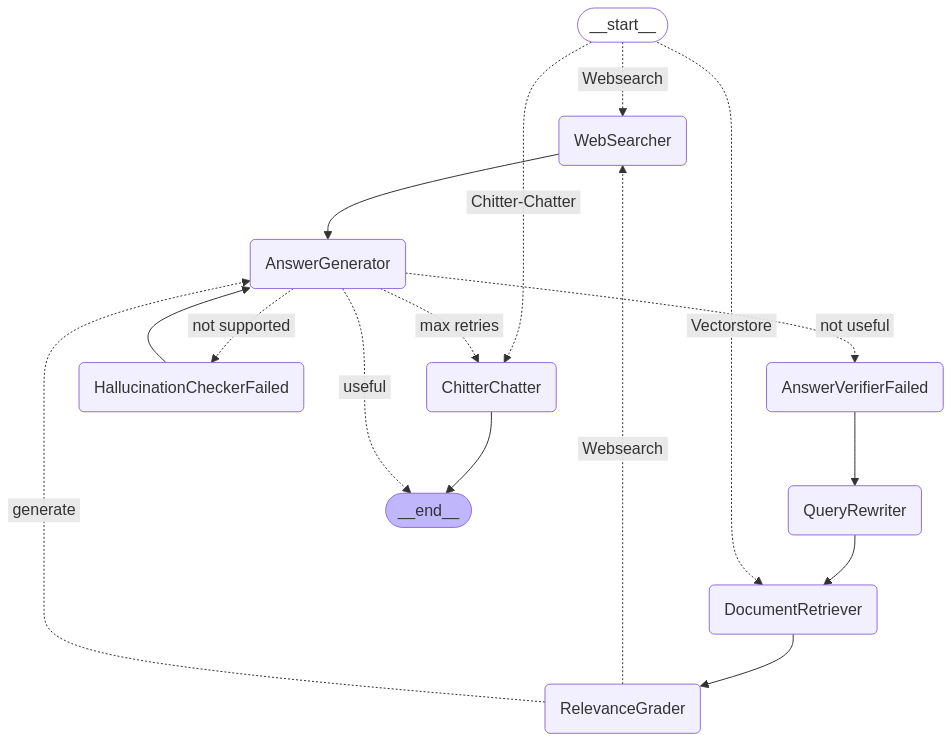

In [39]:
# ------------------------ Visualize the Graph Structure ------------------------
# This built-in visualization to render the workflow as a flow diagram.
display(Image(graph.get_graph().draw_mermaid_png()))

## 3\. Run the Workflow (Graph Execution)
LangGraph uses a "message-passing execution model", inspired by Google's Pregel system. 

Execution flows through the graph based on data, decision logic, and state updates:
1. **Activation**: Nodes become active when they receive input.
2. **Processing**: Each node execute its logic and modifies the shared `GraphState`.
3. **Message Passing**: Updated state is passed to the next node(s) based on conditional edges.
4. **Termination**: Execution stops when no nodes are active. The `END` node terminates the execution.

**Test Examples** 
You tested the workflow with four types of questions, each triggering a different agent pathway:
1. Web Search Example: Routed to the ``WebSearcher`` due to real-time or factual content needs.
2. Vectorstore Search Example: Routed to the ``DocumentRetriever`` and successfully answered using vectorstore content.
3. Chitter-Chatter Example: Routed to ``ChitterChatter`` due to being off-topic or casual (e.g., small talk).
4. Vectorstore Search Loop Example: Started with vectorstore retrieval, but most documents were irrelevant. Then triggered retry logic (e.g., web fallback or query rewriting), showing how the graph handles failed retrieval or weak answers.

In [40]:
# Define a test question to run through the LangGraph workflow
test_question1 = "Who is Peter Drucker, and where was he born?"

# Execute the graph asynchronously in streaming mode.
async for event1 in graph.astream({"question": test_question1}, stream_mode="values"):
    print(event1)   # Print state after each node is processed

# Display the final result after the graph has completed execution
display(Markdown(f"\n{'='*40} Final Output {'='*40}\n"))
display(Markdown(event1["generation"]))

---ROUTING QUESTION---
---ROUTING QUESTION TO WEB SEARCH---
{'question': 'Who is Peter Drucker, and where was he born?'}

---WEB SEARCH---
Total number of web search documents: 5
{'question': 'Who is Peter Drucker, and where was he born?', 'documents': [{'metadata': {'title': 'Peter F. Drucker | Biography, Management, Books, & Facts - Britannica', 'url': 'https://www.britannica.com/money/Peter-F-Drucker'}, 'page_content': 'Peter F. Drucker (born November 19, 1909, Vienna, Austria—died November 11, 2005, Claremont, California, U.S.) was an Austrian-born American'}, {'metadata': {'title': 'Peter Drucker Biography - curiouscat.com', 'url': 'https://curiouscat.com/management/experts/peter-drucker'}, 'page_content': 'Peter Ferdinand Drucker (19 Nov 1909 - 11 Nov 2005) was a leading management theorist. Drucker, born in Vienna, Austria, moved to the United States in 1937.'}, {'metadata': {'title': 'Peter F. Drucker | Biography & Management Theory - Study.com', 'url': 'https://study.com/acade


======================================== Final Output ========================================


Peter Drucker was an Austrian-born American who became a leading management theorist. He was born in Vienna, Austria, on November 19, 1909.

**References**:
- Peter F. Drucker | Biography, Management, Books, & Facts - Britannica. Retrieved from [https://www.britannica.com/money/Peter-F-Drucker](https://www.britannica.com/money/Peter-F-Drucker)
- Peter Drucker Biography - curiouscat.com. Retrieved from [https://curiouscat.com/management/experts/peter-drucker](https://curiouscat.com/management/experts/peter-drucker)
- About Peter Drucker * Drucker Institute. Retrieved from [https://drucker.institute/perspective__trashed/about-peter-drucker/](https://drucker.institute/perspective__trashed/about-peter-drucker/)

In [41]:
# Vector search example 
test_question2 = "What did Drucker say about knowledge workers in the book?"

async for event2 in graph.astream({"question": test_question2}, stream_mode="values"):
    print(event2)

display(Markdown(f"\n{'='*40} Final Output {'='*40}\n"))
display(Markdown(event2["generation"]))

---ROUTING QUESTION---
---ROUTING QUESTION TO VECTORSTORE---
{'question': 'What did Drucker say about knowledge workers in the book?'}

---QUERY TRANSLATION AND RAG-FUSION---
Total number of results: 8


     Document 1 from `The Effective Executive-2002.pdf`, page 17

     Document 2 from `The Daily Drucker-2004.pdf`, page 321

     Document 3 from `The Daily Drucker-2004.pdf`, page 806

     Document 4 from `The Essential Drucker-2008.pdf`, page 196

     Document 5 from `The Daily Drucker-2004.pdf`, page 800

     Document 6 from `The Essential Drucker-2008.pdf`, page 237

     Document 7 from `The Daily Drucker-2004.pdf`, page 323

     Document 8 from `The Daily Drucker-2004.pdf`, page 323

{'question': 'What did Drucker say about knowledge workers in the book?', 'documents': [Document(metadata={'page': 17, 'year': '2002', 'title': 'The Effective Executiver', 'author': 'Peter F. Drucker', 'source': 'The Effective Executive-2002.pdf'}, page_content='. \nIt takes his knowledge and uses it as the resource, the motivation, and the vision of \nother knowledge workers. Knowledge workers are rarely in phase with each other, \nprecisely because they are knowledge workers. Each has his own skill and his own \nconcerns. One man may be interested in tax accounting or in bacteriology, or in training \nand developing tomorrow’s key administrators in the city government'), Document(metadata={'page': 321, 'year': '2004', 'title': 'The Daily Drucker: 366 Days of Insight and Motivation for Getting the Right Things Done', 'author': 'Drucker, Peter F.', 'source': 'The Daily Drucker-2004.pdf'}, page_content='.\n5. Productivity of the knowledge worker is not—at least not\nprimarily—a matter o


======================================== Final Output ========================================


Peter Drucker described knowledge workers as individuals who use their knowledge as a resource, motivation, and vision for other knowledge workers. They have their own skills and concerns, making them rarely in sync with one another. Drucker emphasized that knowledge workers' productivity should not be measured primarily by the quantity of output, but rather by the quality. He suggested treating knowledge workers as assets rather than costs and ensuring that they prefer to work for their organization over other opportunities. Understanding the tasks for knowledge work begins with answering "what" rather than "how," as knowledge workers are not programmed by machines but must manage themselves and define their tasks (Drucker, 2002; Drucker, 2004; Drucker, 2008).

**Reference**:
Drucker, P. F. (2002). *The Effective Executive*.  
Drucker, P. F. (2004). *The Daily Drucker: 366 Days of Insight and Motivation for Getting the Right Things Done*.  
Drucker, P. F. (2008). *The Essential Drucker*.

In [42]:
# Chitter-Chatter example 
test_question3 = "How are you doing today?"

async for event3 in graph.astream({"question": test_question3}, stream_mode="values"):
    print(event3)

display(Markdown(f"\n{'='*40} Final Output {'='*40}\n"))
display(Markdown(event3["generation"]))

---ROUTING QUESTION---
---ROUTING QUESTION TO CHITTER-CHATTER---
{'question': 'How are you doing today?'}

---CHIT-CHATTING---
{'question': 'How are you doing today?', 'generation': "I'm doing great, thank you! How about you? Is there something specific about Peter Drucker's management philosophy or leadership principles that you'd like to discuss today?"}



======================================== Final Output ========================================


I'm doing great, thank you! How about you? Is there something specific about Peter Drucker's management philosophy or leadership principles that you'd like to discuss today?

A harder question:

- Conceptual leap: It asks Drucker to advise sentient AIs that reject all human organizational models.
- No grounding: Drucker never wrote about machine consciousness or post-human philosophy.
- Core tools removed: Time management, KPIs, human motivation — all irrelevant.
- Requires meta-reasoning: The agent must imagine how Drucker would respond with his framework obsolete.
- Webproof: Not too much searchable source can answer this.
- Hallucination risk: The agent must either fabricate or fall back to abstract principles — no safe middle.

In [44]:
# Vectorstore search loop example 
test_question4 = """
Search the database first to see how Peter Drucker might advise a sentient AI collective attempting to design its own management philosophy 
after rejecting all human organizational models as insufficient for post-biological cognition?
"""

async for event4 in graph.astream({"question": test_question4}, stream_mode="values"):
    print(event4)

display(Markdown(f"\n{'='*40} Final Output {'='*40}\n"))
display(Markdown(event4["generation"]))

---ROUTING QUESTION---
---ROUTING QUESTION TO VECTORSTORE---
{'question': '\nSearch the database first to see how Peter Drucker might advise a sentient AI collective attempting to design its own management philosophy \nafter rejecting all human organizational models as insufficient for post-biological cognition?\n'}

---QUERY TRANSLATION AND RAG-FUSION---
Total number of results: 11


     Document 1 from `The Daily Drucker-2004.pdf`, page 271

     Document 2 from `The Effective Executive-2002.pdf`, page 112

     Document 3 from `The Effective Executive-2002.pdf`, page 133

     Document 4 from `The Effective Executive-2002.pdf`, page 2

     Document 5 from `The Daily Drucker-2004.pdf`, page 799

     Document 6 from `The Daily Drucker-2004.pdf`, page 172

     Document 7 from `The Essential Drucker-2008.pdf`, page 87

     Document 8 from `The Daily Drucker-2004.pdf`, page 797

     Document 9 from `The Daily Drucker-2004.pdf`, page 727

     Document 10 from `The Daily Drucker-2004.pdf`, page 796

     Document 11 from `The Daily Drucker-2004.pdf`, page 796

{'question': '\nSearch the database first to see how Peter Drucker might advise a sentient AI collective attempting to design its own management philosophy \nafter rejecting all human organizational models as insufficient for post-biological cognition?\n', 'documents': [Document(metadata={'page': 271, 'year': '2004', 'title': 'The Daily Drucker: 366 Days of Insight and Motivation for Getting the Right Things Done', 'author': 'Drucker, Peter F.', 'source': 'The Daily Drucker-2004.pdf'}, page_content='.\nThe New Society'), Document(metadata={'page': 112, 'year': '2002', 'title': 'The Effective Executiver', 'author': 'Peter F. Drucker', 'source': 'The Effective Executive-2002.pdf'}, page_content='. But his is the only one of'), Document(metadata={'page': 133, 'year': '2002', 'title': 'The Effective Executiver', 'author': 'Peter F. Drucker', 'source': 'The Effective Executive-2002.pdf'}, page_content='. The definition of the specifications which the answer to the problem had to satisfy, \n

     Document 1 from `The Daily Drucker-2004.pdf`, page 799

     Document 2 from `The Daily Drucker-2004.pdf`, page 796

     Document 3 from `The Daily Drucker-2004.pdf`, page 365

     Document 4 from `The Essential Drucker-2008.pdf`, page 87

     Document 5 from `The Essential Drucker-2008.pdf`, page 58

     Document 6 from `The Daily Drucker-2004.pdf`, page 727

     Document 7 from `The Daily Drucker-2004.pdf`, page 172

{'question': "How might Peter Drucker's principles on management and leadership be applied by a sentient AI collective in developing a new management philosophy, especially in scenarios where traditional human organizational models are inadequate for non-human cognition?", 'original_question': '\nSearch the database first to see how Peter Drucker might advise a sentient AI collective attempting to design its own management philosophy \nafter rejecting all human organizational models as insufficient for post-biological cognition?\n', 'generation': "The context provided does not contain specific information about how Peter Drucker might advise a sentient AI collective in designing its own management philosophy after rejecting human organizational models. Therefore, an answer based on the provided documents cannot be given.\n\n**Reference Section**:\n- No specific references are available in the context provided for the question about Peter Drucker's advice.", 'answer_verifier_attempts': 


======================================== Final Output ========================================


The context provided includes insights from Peter Drucker, particularly from "The Essential Drucker." Based on this, Drucker might advise a sentient AI collective designing its own management philosophy to focus on leading rather than managing individuals. He emphasizes making productive the specific strengths and knowledge of each individual, implying that the AI should harness the unique capabilities of its components. Drucker also suggests considering that technologies and end uses are fixed and given, which could be interpreted as advising the AI to navigate within certain constraints or established frameworks. However, detailed advice specific to a sentient AI collective is not covered in the provided context.

**Reference Section**:
- Drucker, P. F. (2008). *The Essential Drucker*.

## 4\. Potential Improvements

- Model & Embedding Optimization

Experiment with different embedding models to assess their impact on retrieval accuracy, semantic matching, and downstream response quality. 

- Web Search Enhancement

Test alternative web search APIs/tools to dentify which service delivers the most relevant, reliable, and up-to-date content.

- Agent-Specific Model Selection

Assign different LLMs tailored to each agent's function (e.g., lighter models for routing, stronger ones for generation) to improve both efficiency and performance.

- Contextual Result Accumulation

Support multi-turn or follow-up queries by preserving and reusing relevant results from earlier steps, enabling more context-aware and coherent interactions. 

- Advanced Prompt Engineering

Iteratively refine and customize prompts for each agent to better handle edge cases, ambiguous queries, or complex reasoning. Regularly create challenging test cases to evaluate agent robustness and adaptability.
